Updated: 19 September 2023

In [1]:
from hmcollab import datasets
from hmcollab.directory_tree import HMDatasetDirectoryTree
from hmcollab import directories
from hmcollab import articles
from hmcollab import transactions
from hmcollab import models
from hmcollab import scoring

In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import Image, display
from datetime import datetime, timedelta

In [3]:
from display_data import display_article, display_articles

## Aim: Explore performance with filtered article dataset
+ It is important to note that I first create the dummies from the full articles dataset, then I remove those articles with transactions below a cutoff point. ArticleKNN_new uses the full number dummies on a smaller dataset (filtered)
+ kmeans uses the full number of dummies (centroids need to match to ArticleKNN_new.shape)

## Toy dataset: standard split

In [4]:
toy_tree = HMDatasetDirectoryTree(directories.data("toy"))
toy = datasets.HMDataset(tree=toy_tree, folds='twosets')   
print('Transactions shape: ', toy.transactions.shape)
print('Unique customers: ',toy.transactions.customer_id.unique().shape)
print('Train_x:', toy.train_x.shape) 
print('Train_y:', toy.train_y.shape) 
print('Unique customers train_x: ',toy.train_x.customer_id.unique().shape)
print('Original relevant set from Target class: ',toy.relevant_set.shape)

Transactions shape:  (630673, 5)
Unique customers:  (10000,)
Train_x: (475677, 5)
Train_y: (28418, 5)
Unique customers train_x:  (7350,)
Original relevant set from Target class:  (10000, 2)


print('Unique customers train_y: ',toy.train_y.customer_id.unique().shape)

### Filter articles

Getting the article IDs

In [5]:
toy_threshold = 50
toy_filtered_article_ids = models.filter_articles(toy.transactions, threshold=toy_threshold)
print('There are {} articles with {} or more transactions'.format(len(toy_filtered_article_ids), toy_threshold))

There are 1626 articles with 50 or more transactions


### Create dummies for all articles and then prune it

In [6]:
toy_dummies = articles.ArticleFeaturesSimpleFeatures(toy.articles, use_article_id=True).x
toy_dummies.shape

(62991, 637)

Observe that there are more dummies than samples. This is the input for ArticleKNN_new

In [7]:
filtered_dummies = toy_dummies[toy_dummies.article_id.isin(
            toy_filtered_article_ids)].drop(columns="article_id")
filtered_dummies.shape

(1626, 636)

## Model

Let's find the cutomers at train_x with transactions at train_y

In [8]:
toy_train_x_customer_ids = toy.train_x.customer_id.unique()
toy_trainx_customer_ids_at_y = toy_train_x_customer_ids[np.isin(toy_train_x_customer_ids,toy.train_y.customer_id.unique())]
len(toy_trainx_customer_ids_at_y)

7350

In [9]:
toy_knn = models.KnnRecommender(toy, toy_dummies)  # already using only train set

**Recommend for the first customer in the training set**

In [10]:
toy_train_x_customer_ids = toy.train_x.customer_id.unique()
toy.train_x.loc[toy.train_x.customer_id==toy_trainx_customer_ids_at_y[0],:].shape

(75, 5)

In [11]:
toy.train_x.loc[toy.train_x.customer_id==toy_trainx_customer_ids_at_y[0],:].article_id.nunique()

68

In [12]:
# Recommendations for the first customer
toy_recommendations_1st = toy_knn.recommend(toy_trainx_customer_ids_at_y[0])
toy_recommendations_1st

['0729928001',
 '0842062003',
 '0666448007',
 '0811198001',
 '0448509018',
 '0539723005',
 '0675070015',
 '0680374001',
 '0349301001',
 '0502224001',
 '0108775015',
 '0538699001']

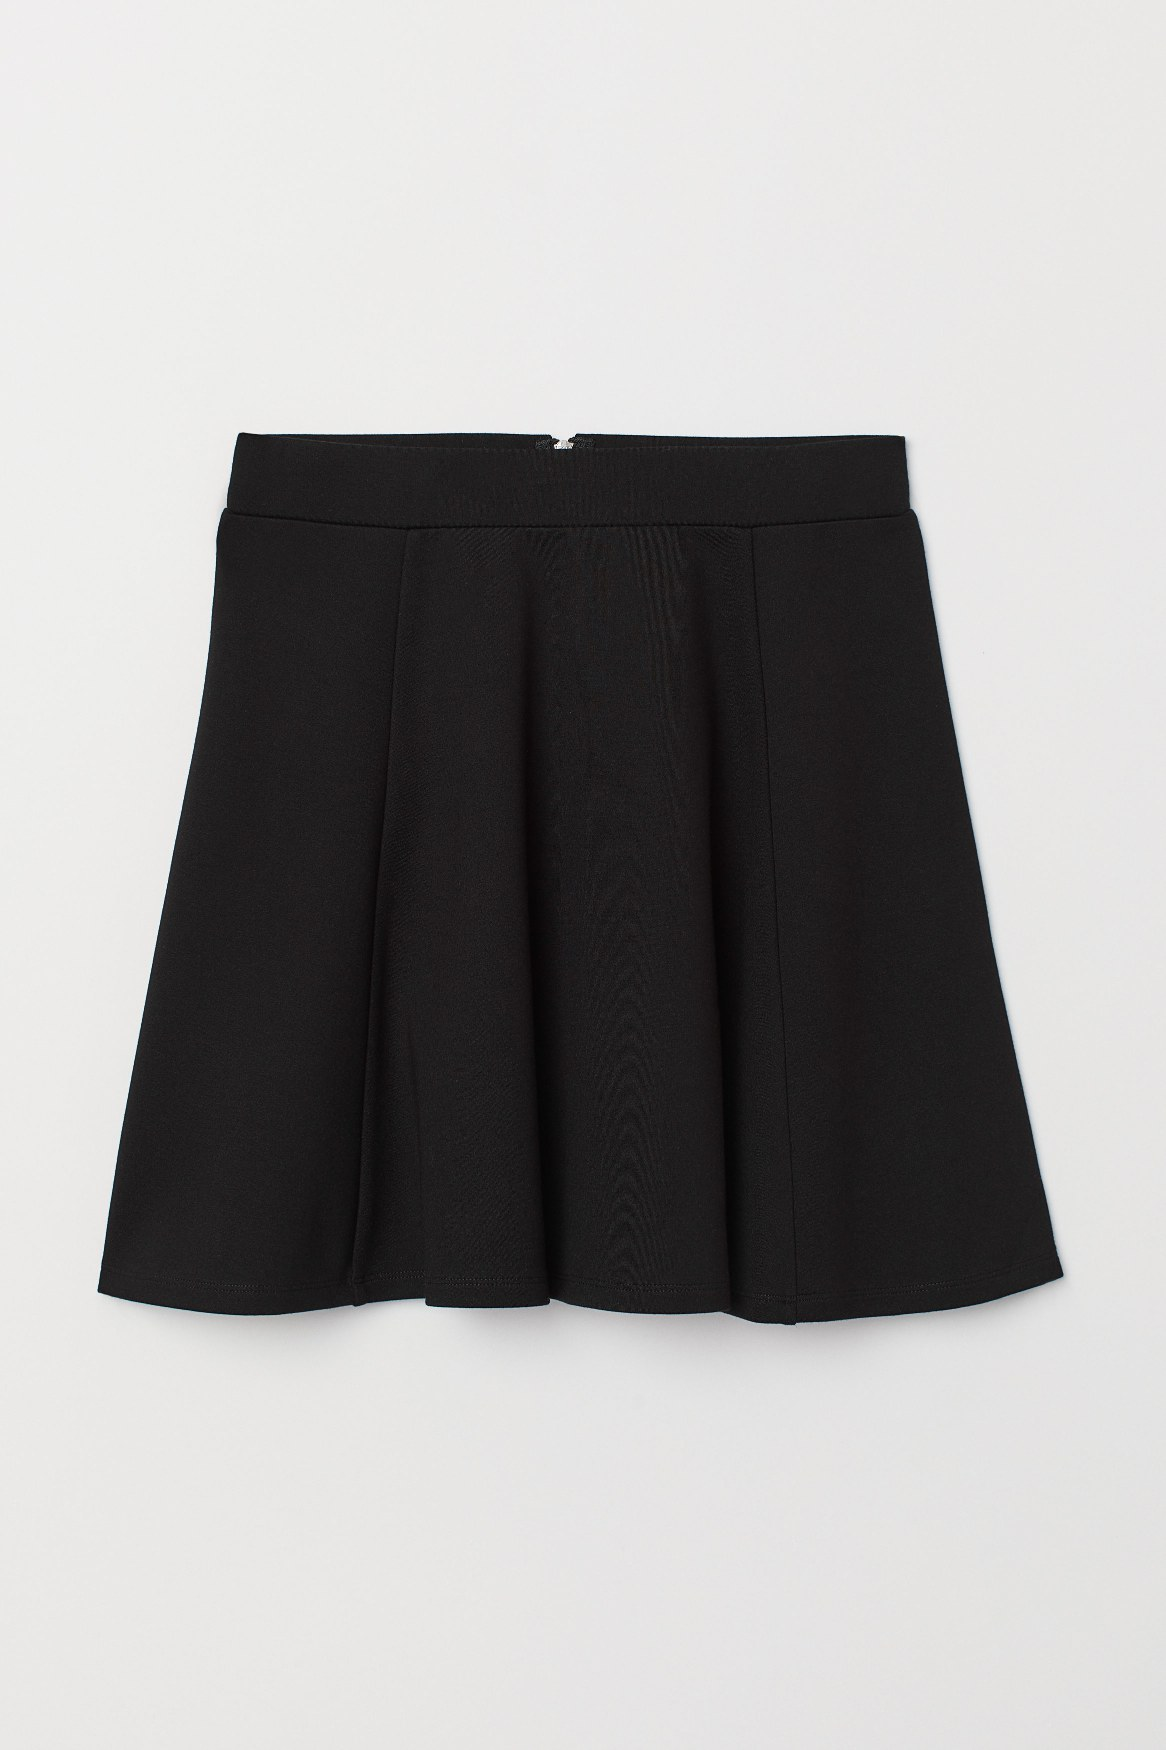

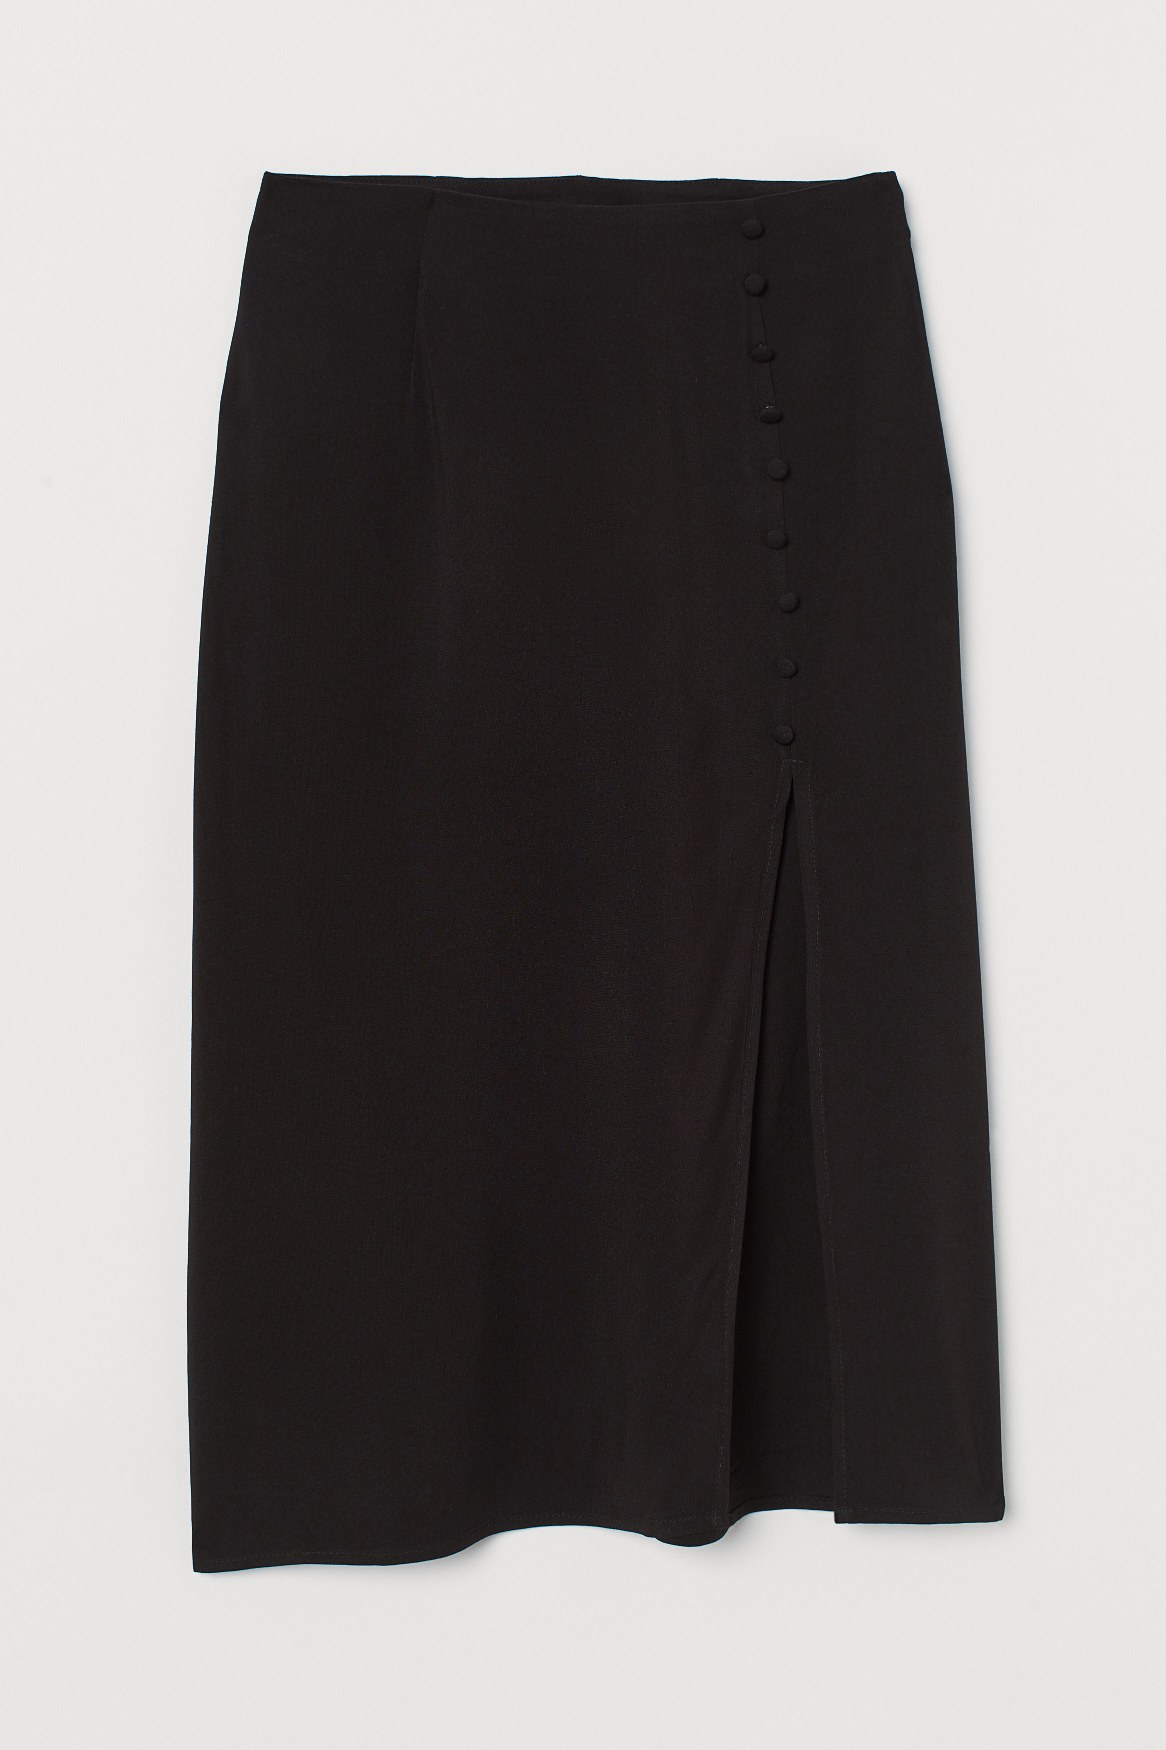

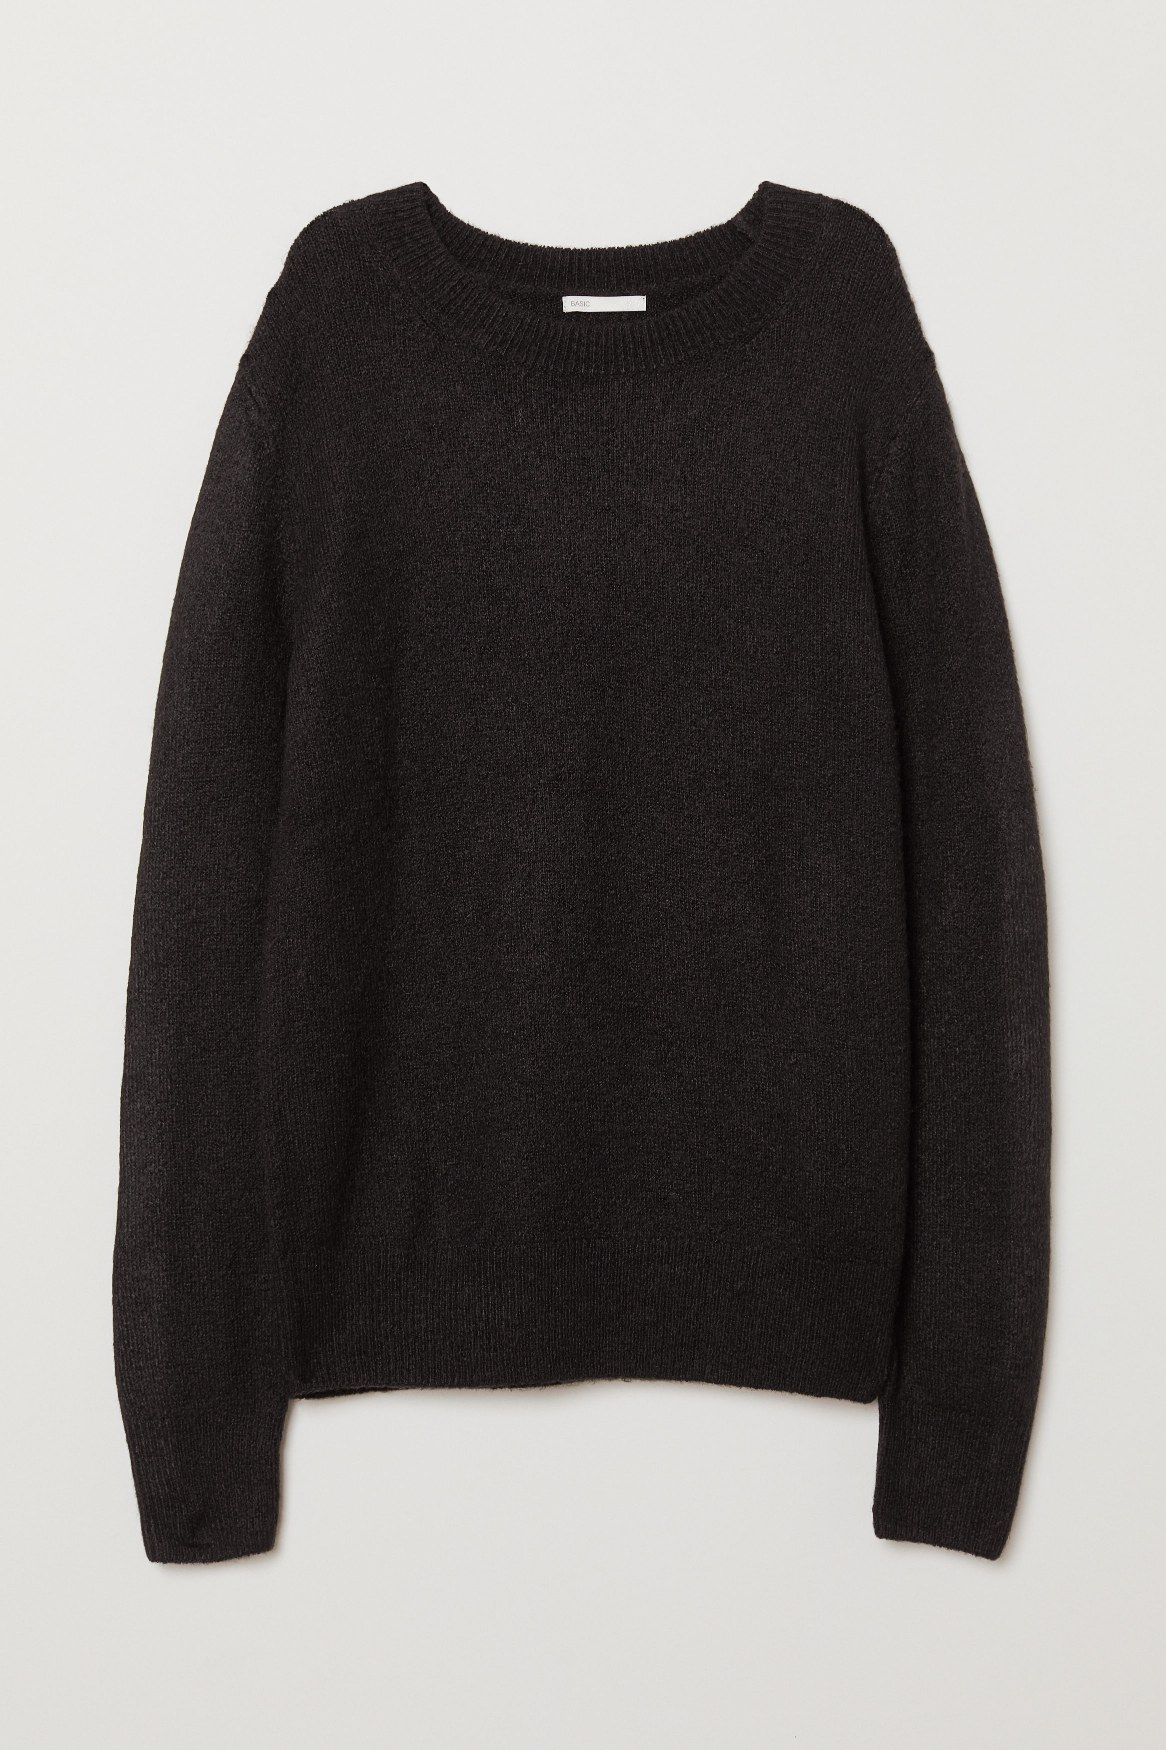

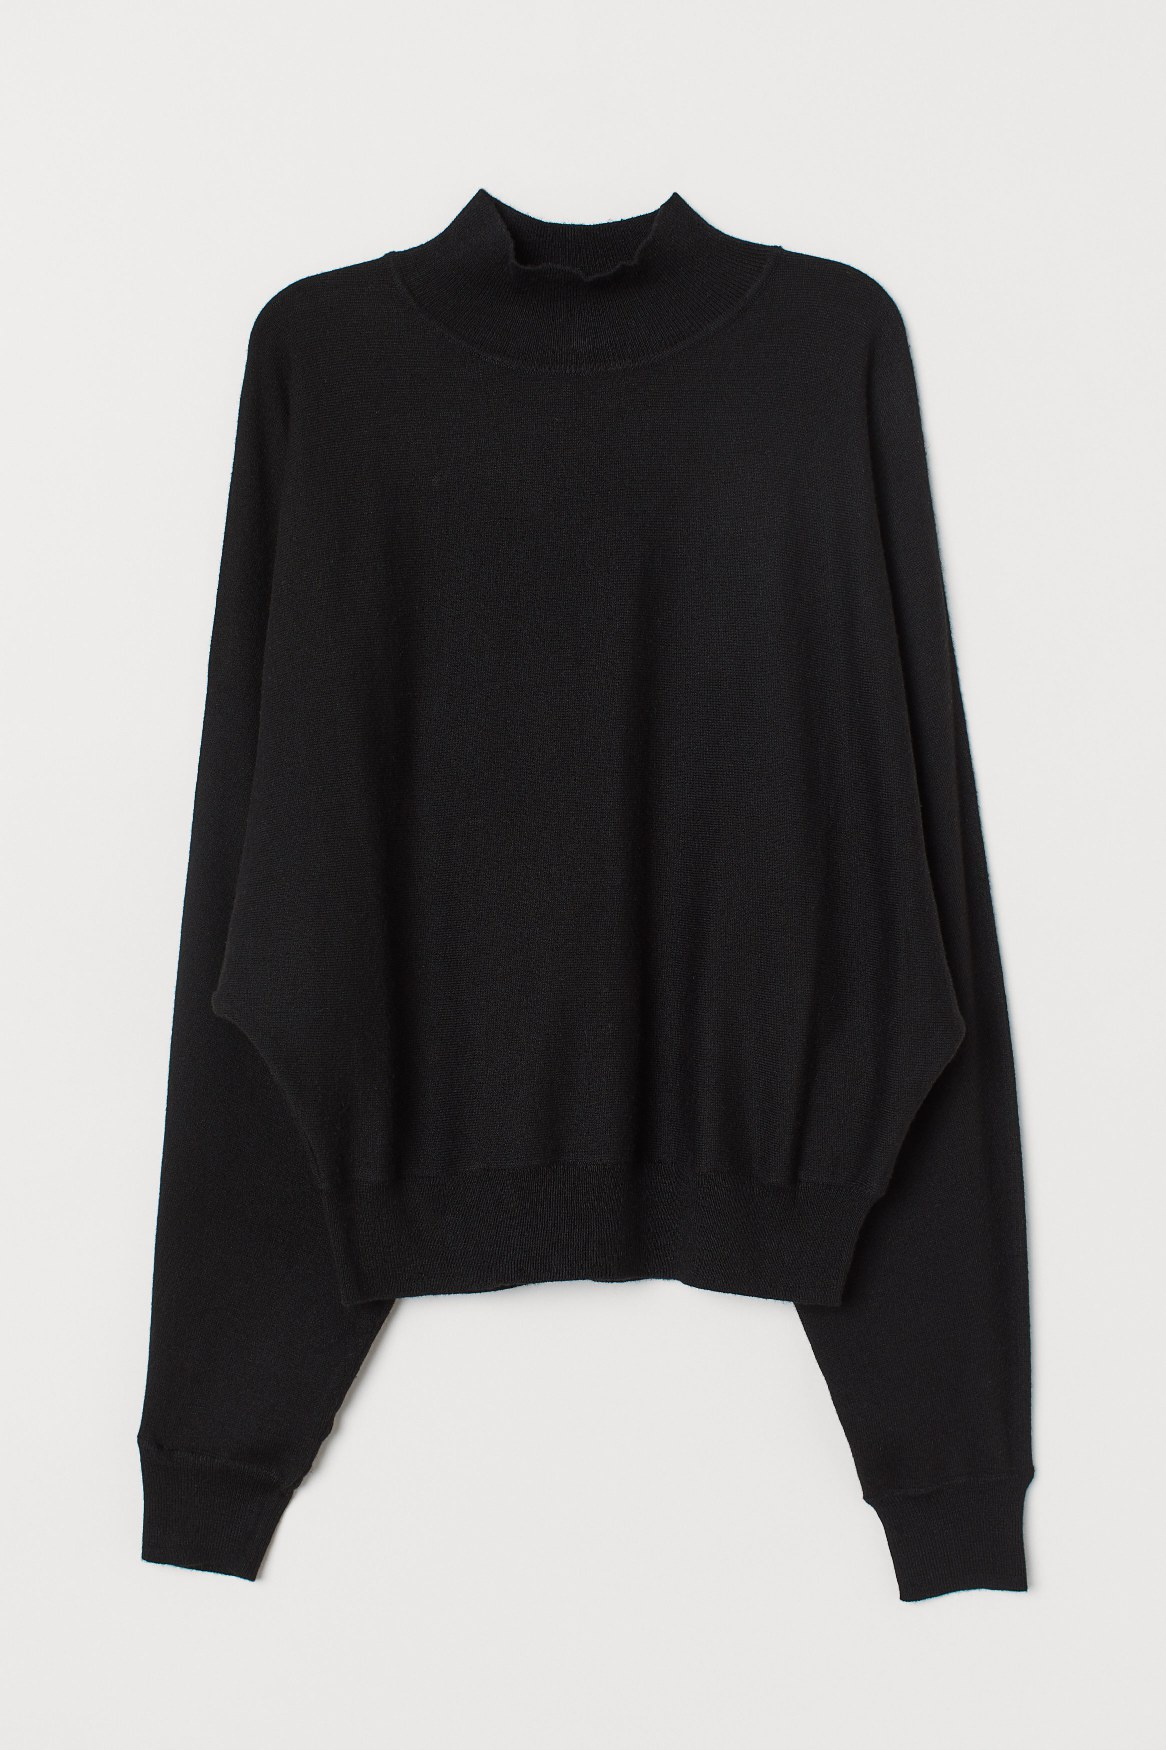

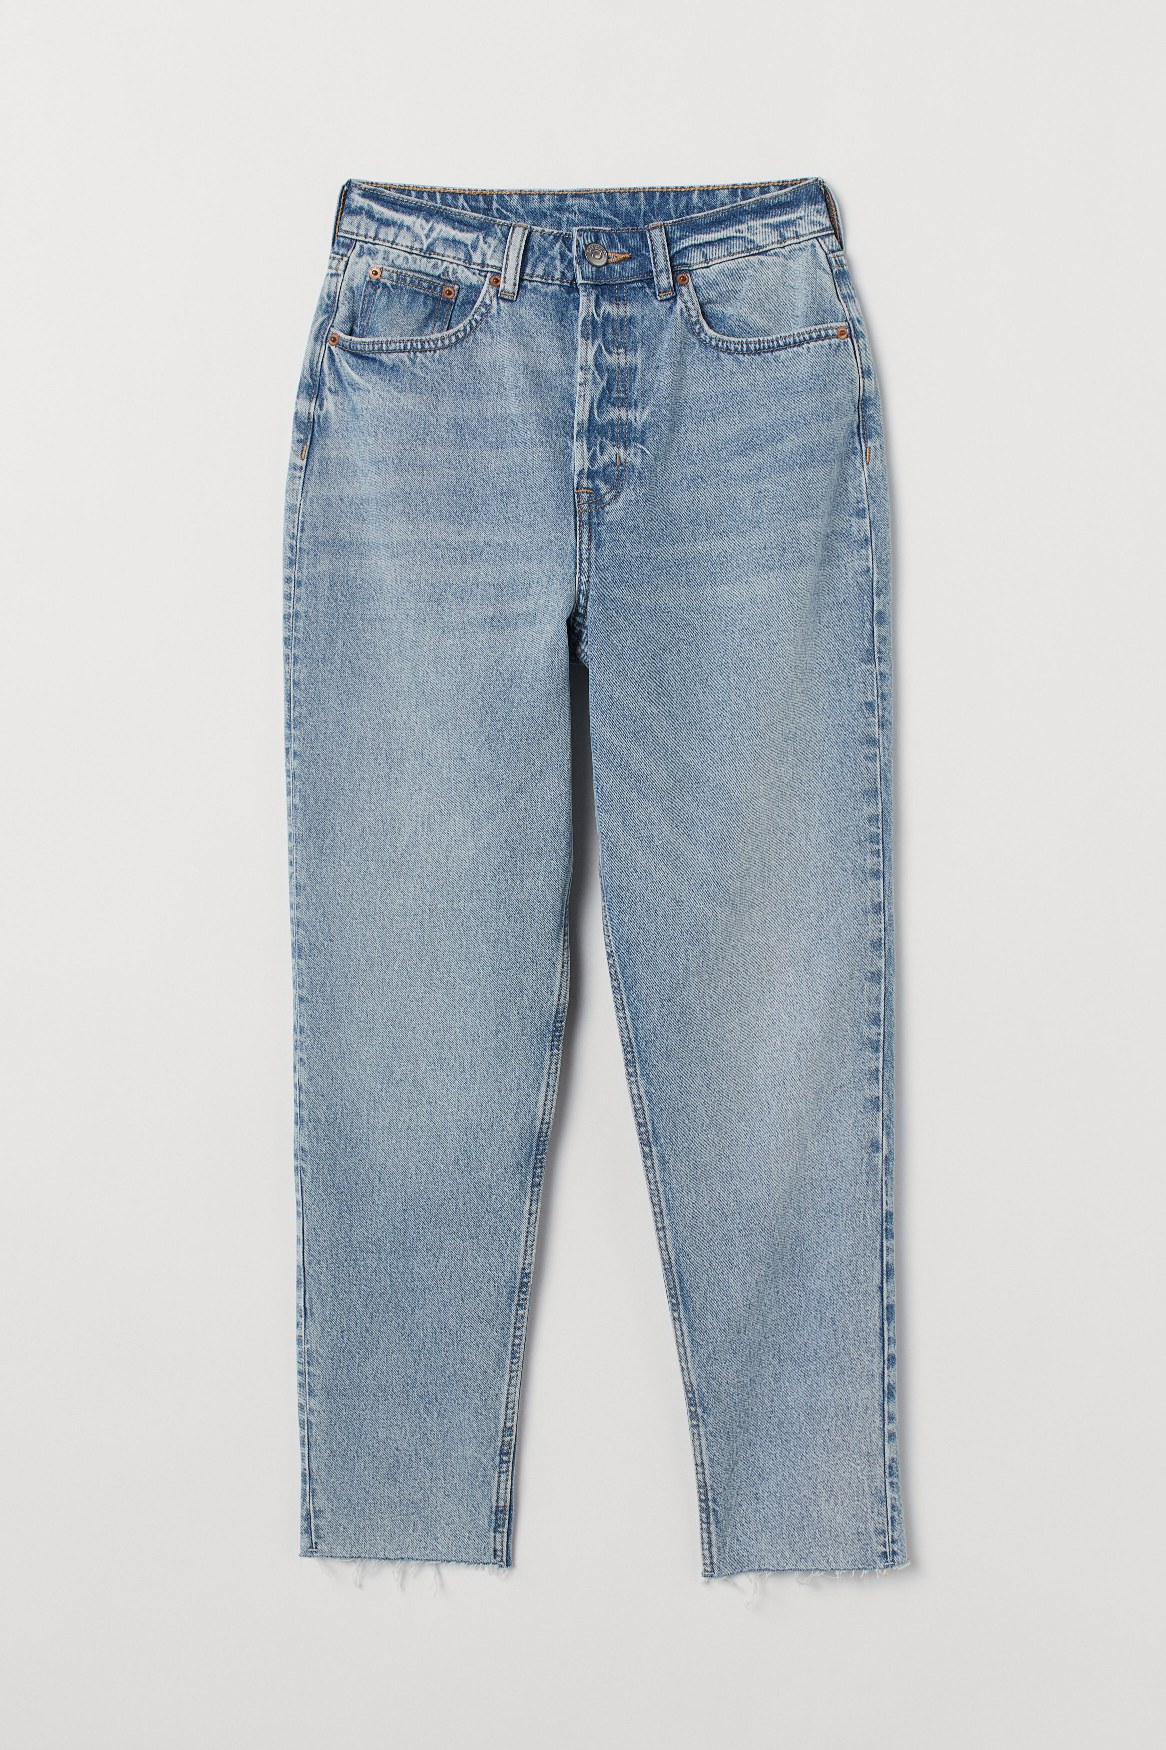

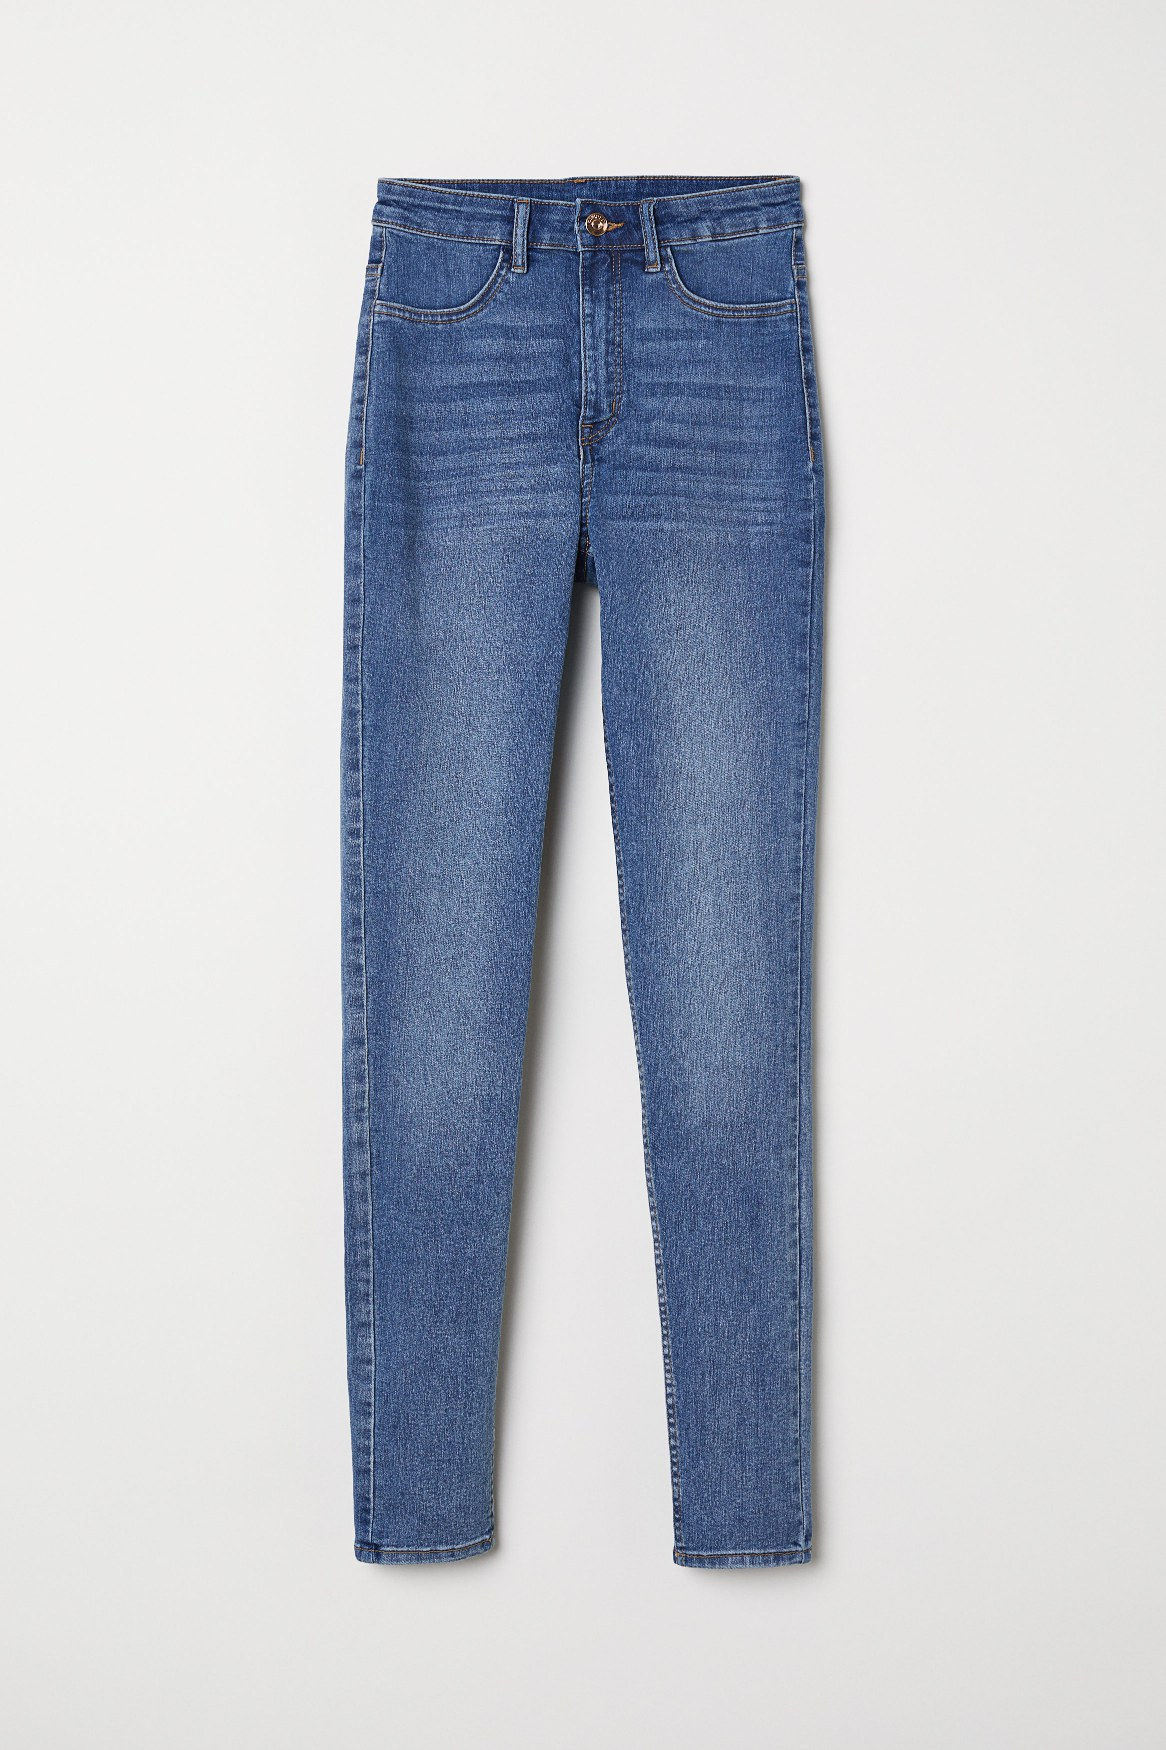

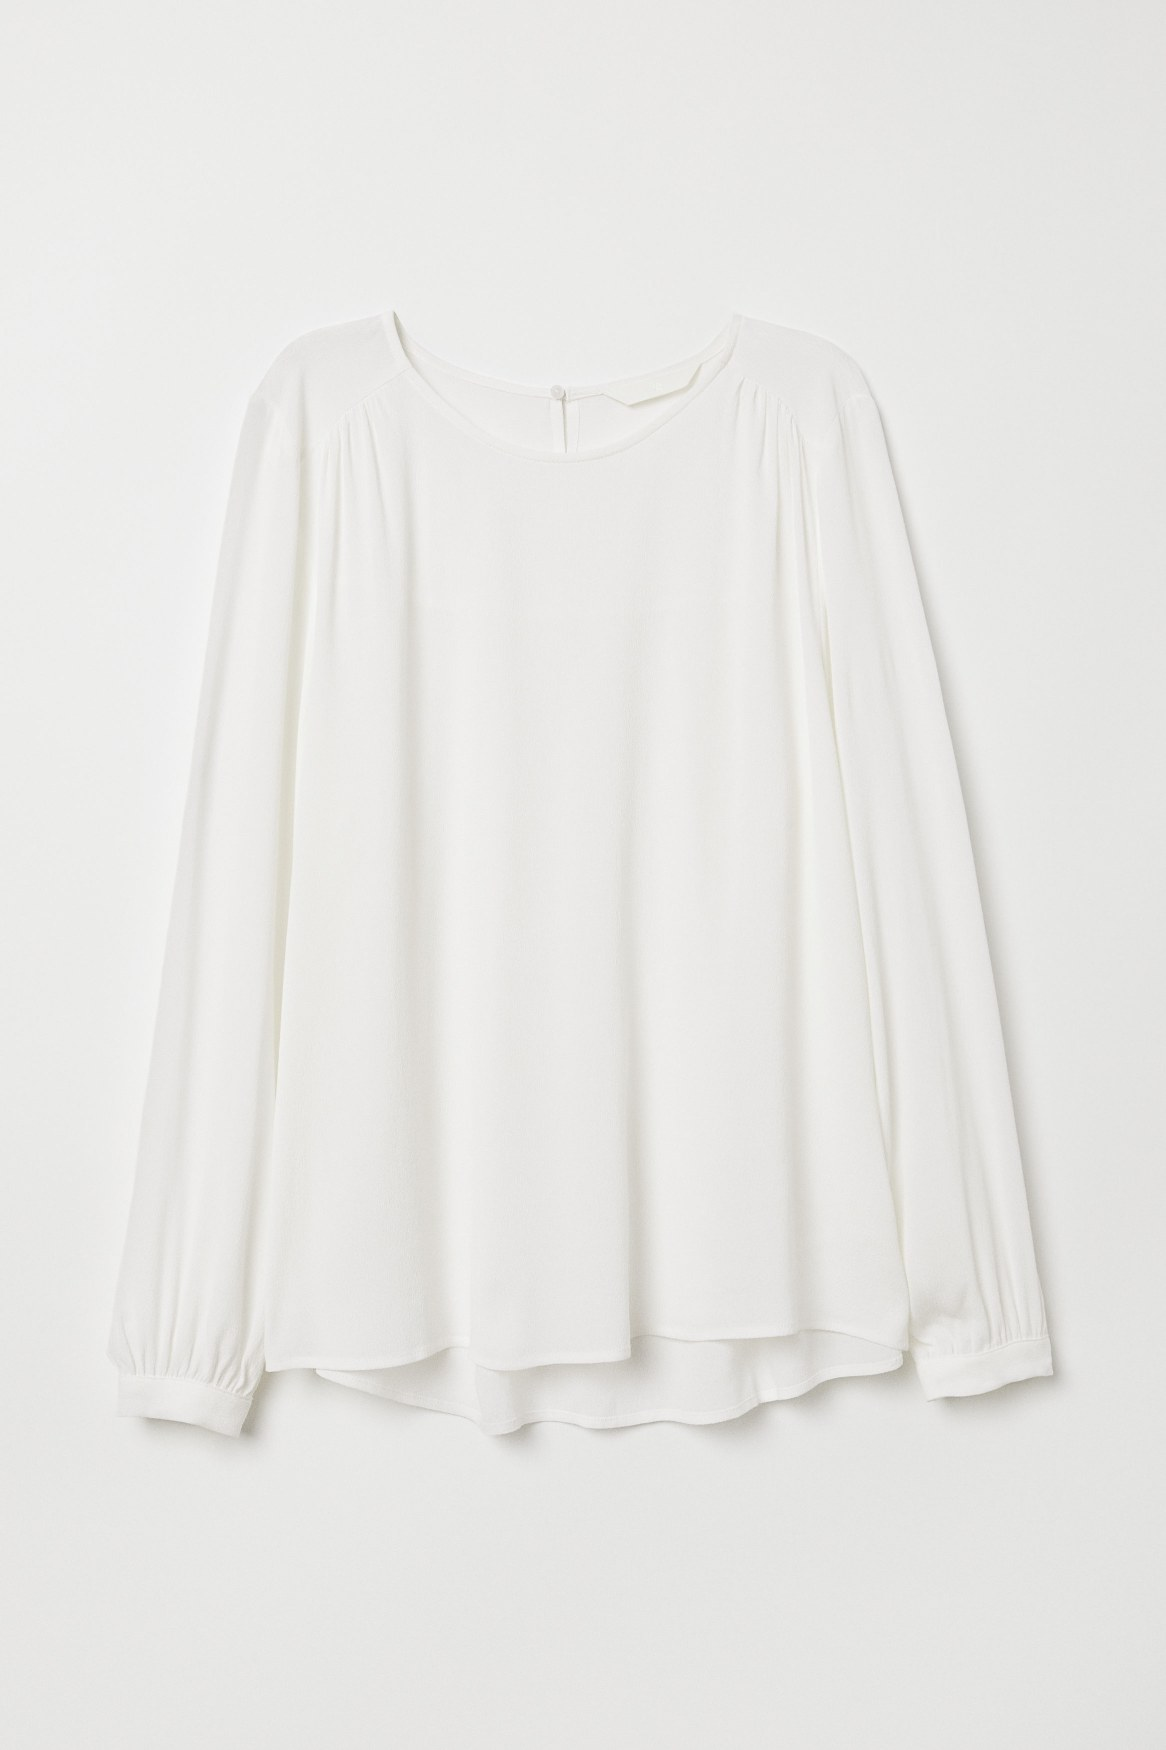

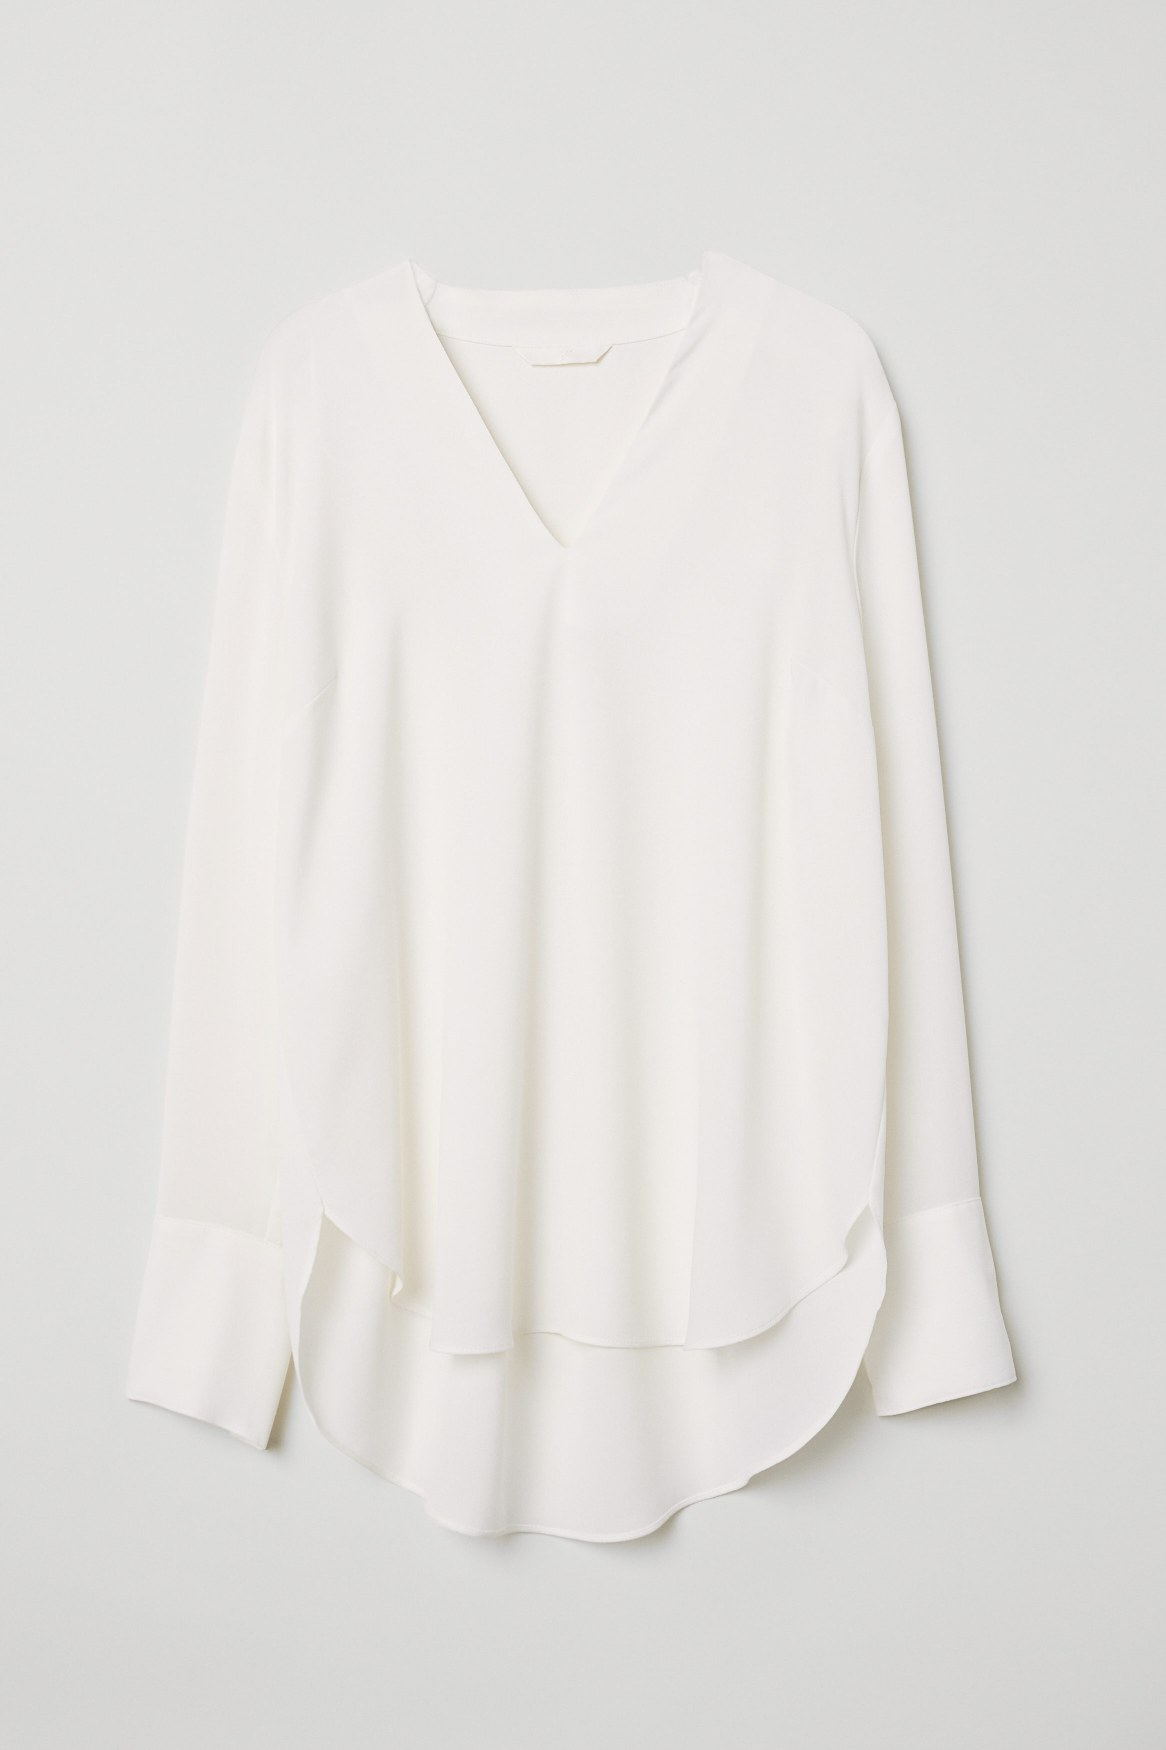

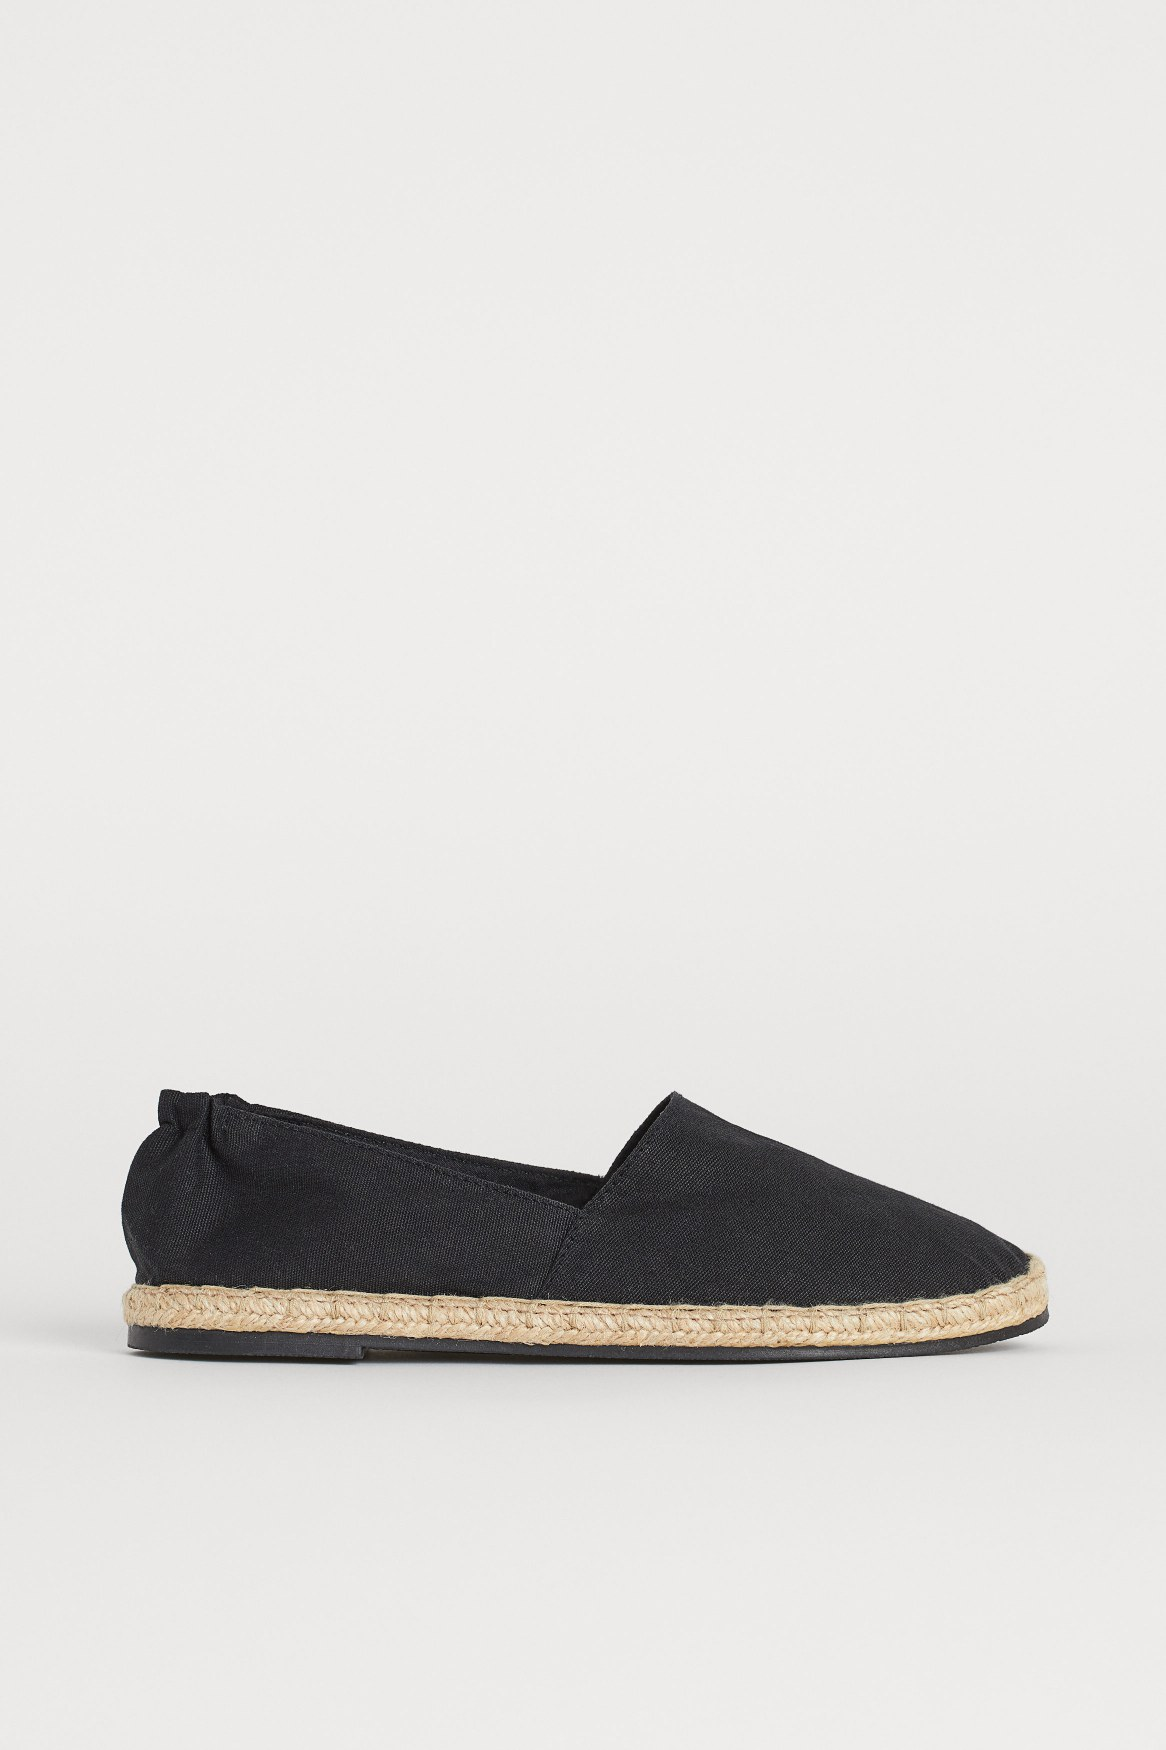

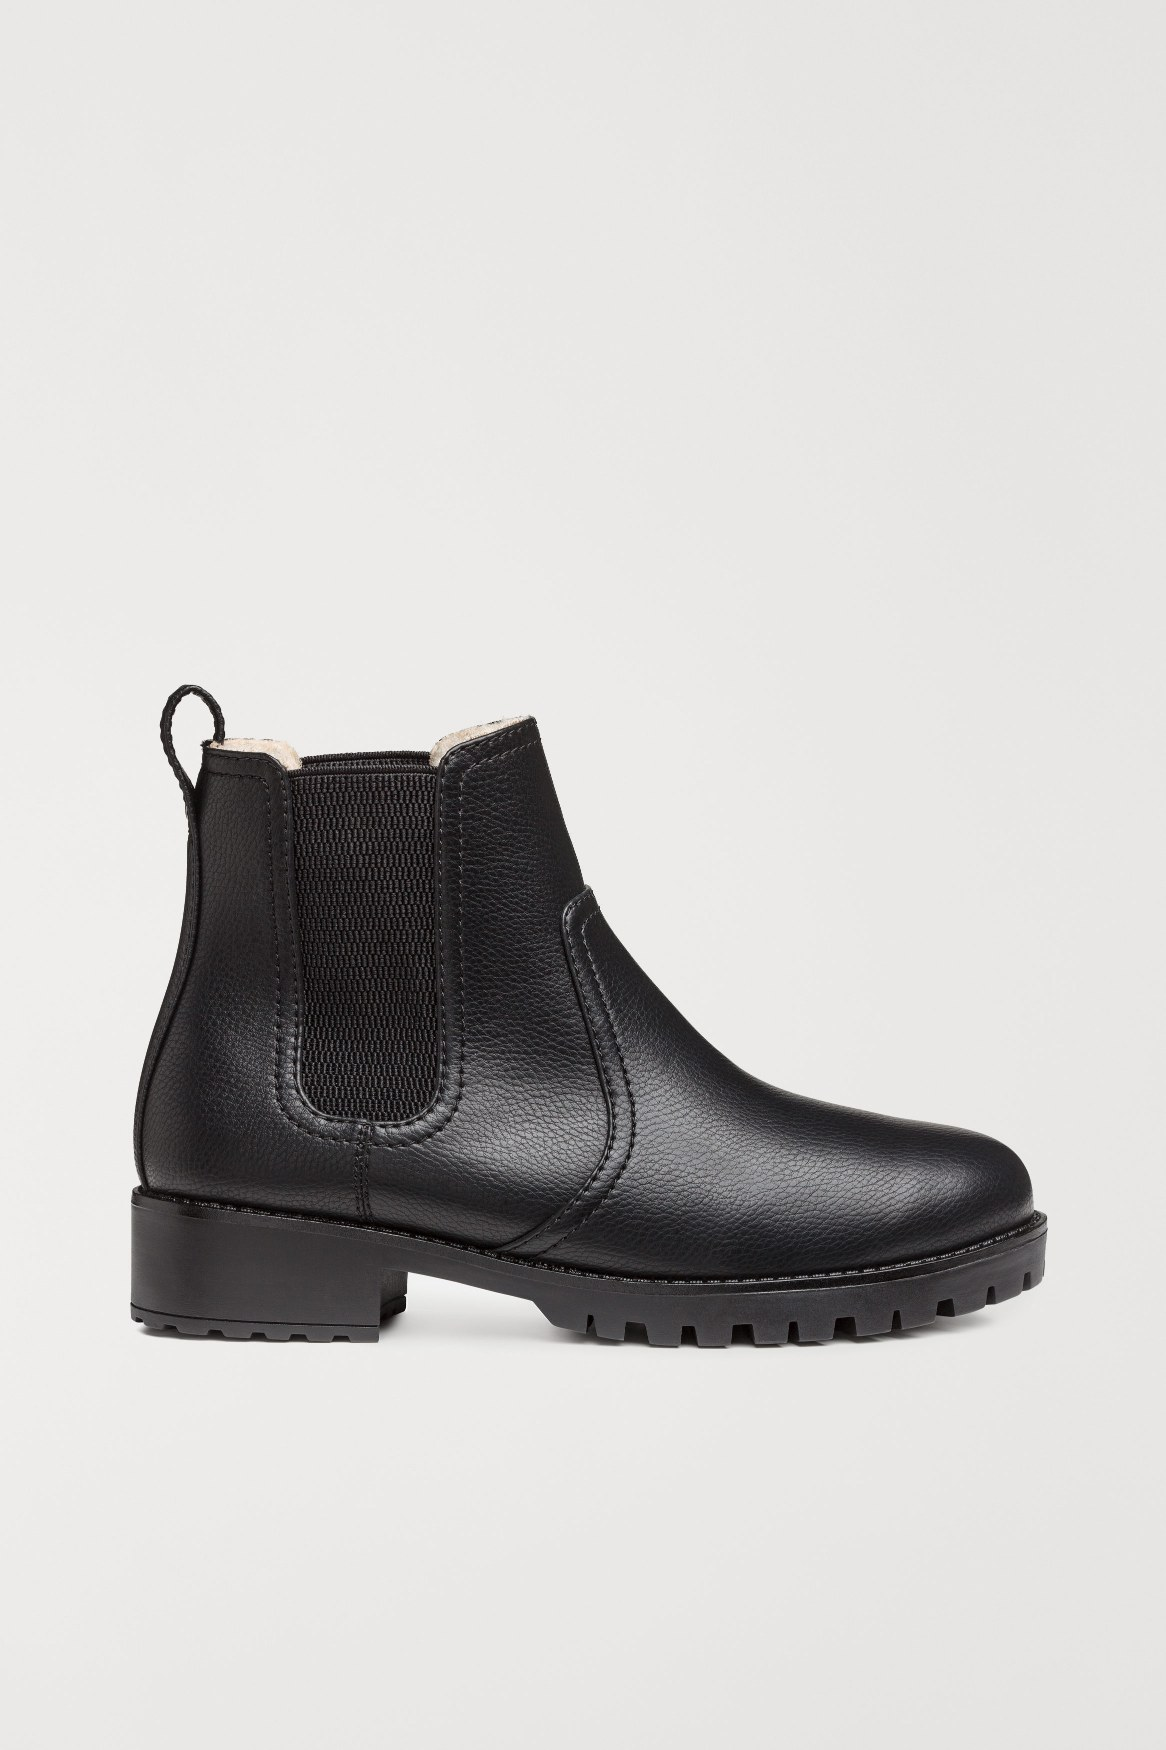

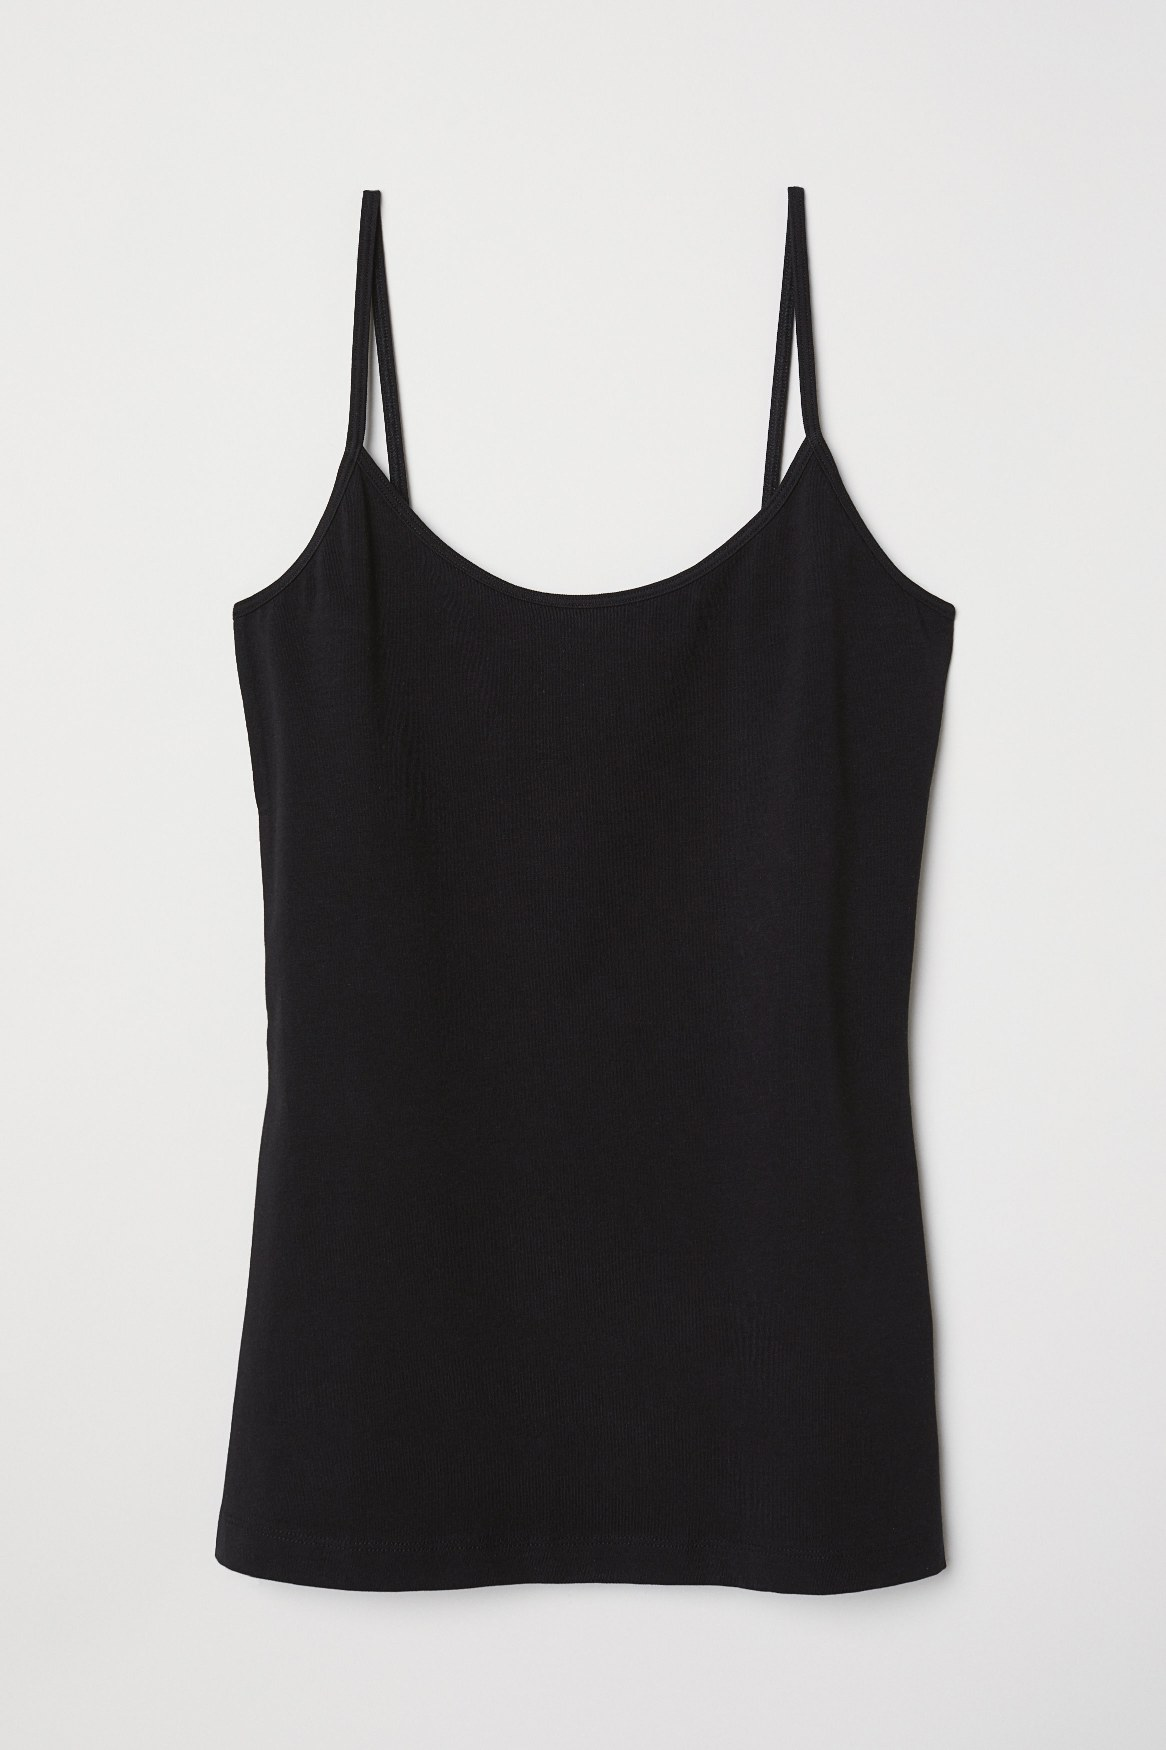

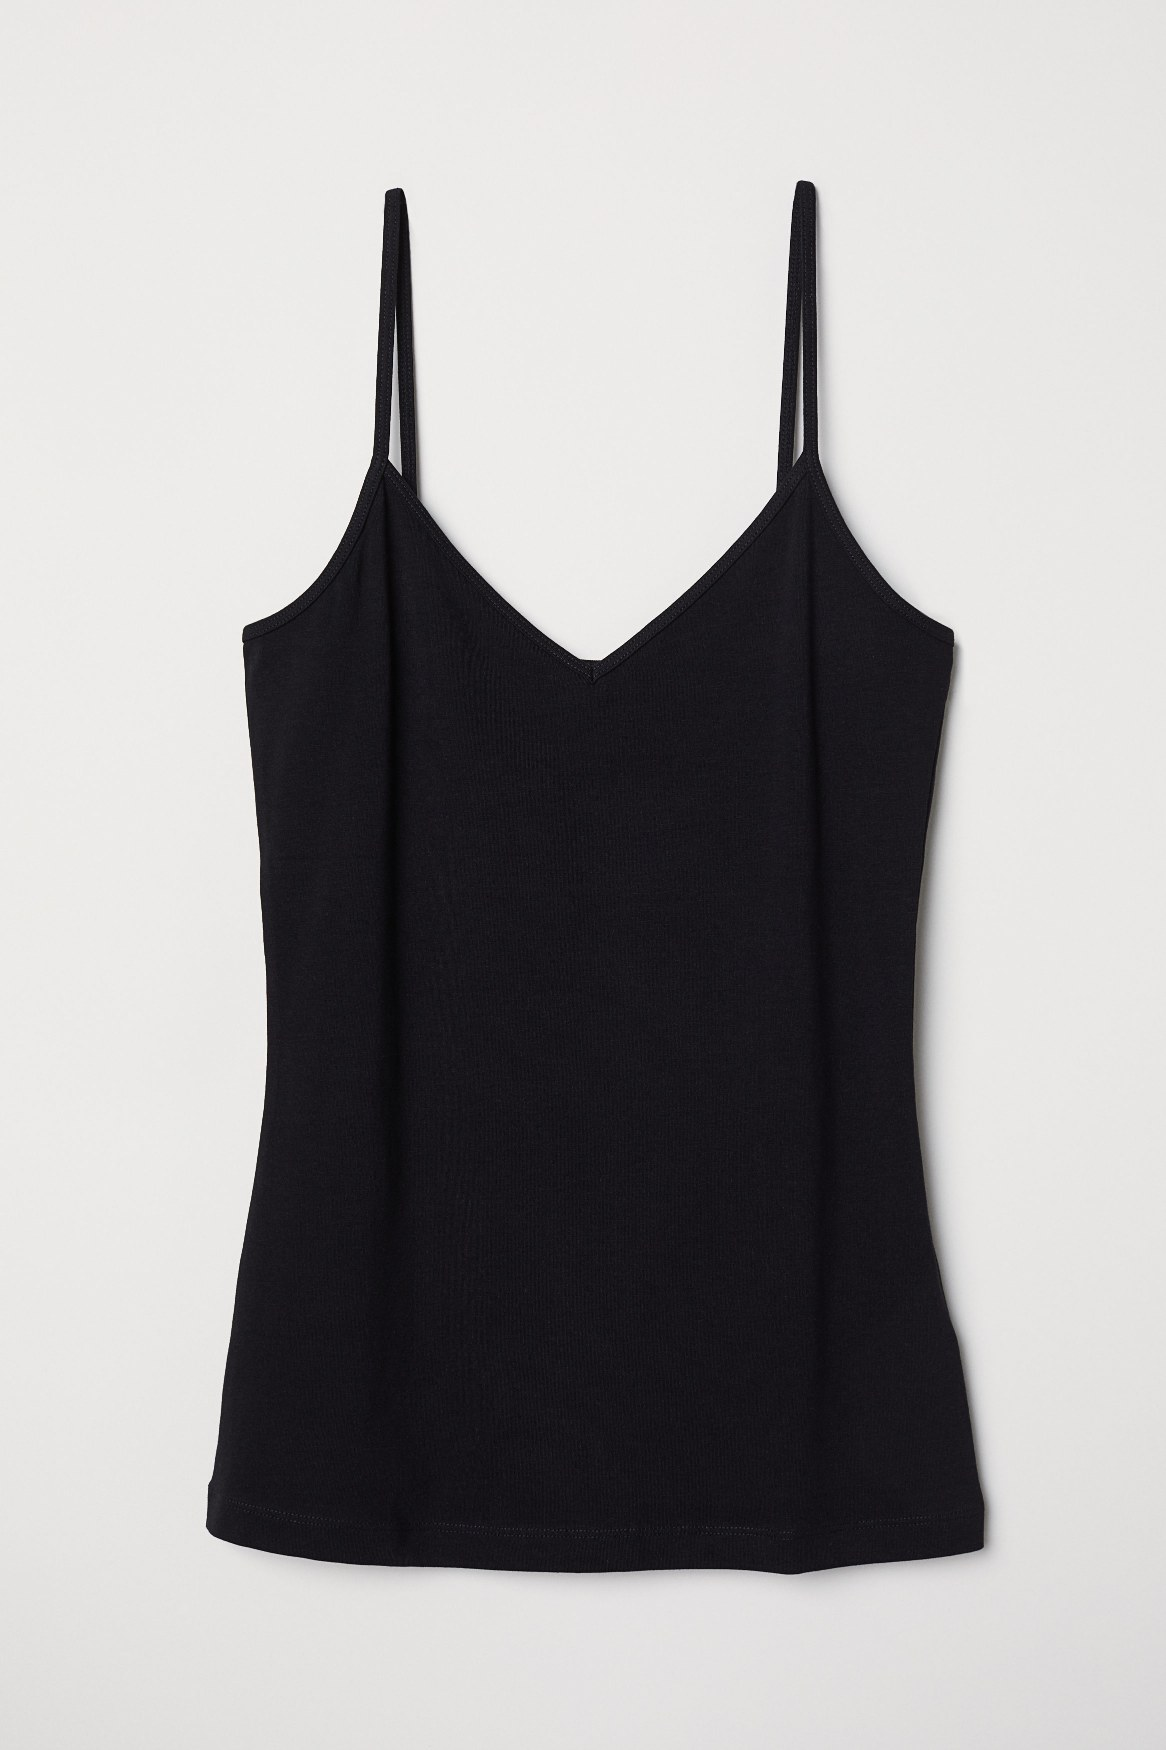

In [13]:
display_articles(toy, toy_recommendations_1st)

## Recommend all in train_x
Train_x has 10815 unique customers, recommend to all is time consuming. We will recommend for the intersection of cutomers with purchases in the last week (train_y) with purchases at train_x (otherwise a cold start)

In [14]:
toy_trainx_c_ids_with_y = toy_train_x_customer_ids[np.isin(toy_train_x_customer_ids,toy.train_y.customer_id.unique())]  


In [15]:
begin = datetime.now()
toy_recommendations_y_customers = toy_knn.recommend_all(toy_trainx_c_ids_with_y)   
print('Seconds: ', (datetime.now() - begin).total_seconds())
toy_recommendations_y_customers.head()

Seconds:  1893.411212


,customer_id,prediction
0,01959be607170cc2f092ee8fd13eda251b13cde70ef38d...,0729928001 0842062003 0666448007 0811198001 04...
1,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0349301001 0502224001 0564309022 0685813001 05...
2,03fe6234ee5446aacaf41c77be890197f5c40ab1c14195...,0524825011 0562245001 0502224001 0349301001 07...
3,04573d1d88236664b9c68bd2e4e163467b53bea966bbd4...,0355072001 0355569001 0564786001 0678687001 07...
4,05a7beb1c0c6615415a2817654bc29c6a37f7e004bb20f...,0915526001 0762205005 0469137001 0537116001 03...


## Scores for toy dataset

In [18]:
# After filtering map_at_k improved from 0 to 0.000543 
rel_y = datasets.target_to_relevant(toy.train_y)
t = scoring.relevant(toy_recommendations_y_customers, rel_y)
print('t has {} records \n'.format(t.shape[0]))

print("ap_at_k:")
print(t.apply(scoring.ap_at_k),'\n')

print("map_at_k:", scoring.map_at_k(t))

t has 7350 records 

ap_at_k:
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
7345    0.000000
7346    0.000000
7347    0.017857
7348    0.000000
7349    0.000000
Length: 7350, dtype: float64 

map_at_k: 0.0005439015192416553


## Full dataset: standard split

In [19]:
# folds='standard' uses all customers for training and creates validation and test set with the last 2 weeks
full = datasets.HMDataset(folds='twosets')   
print('Transactions shape: ', full.transactions.shape)
print('Unique customers: ',full.transactions.customer_id.unique().shape)
print('Train_x:', full.train_x.shape) 
print('Train_y:', full.train_y.shape) 
print('Unique customers train_x: ',full.train_x.customer_id.unique().shape)
print('Original relevant set from Target class: ',full.relevant_set.shape)

Transactions shape:  (31788324, 5)
Unique customers:  (1362281,)
Train_x: (25208739, 5)
Train_y: (212299, 5)
Unique customers train_x:  (1084889,)
Original relevant set from Target class:  (75481, 2)


### Create dummies for all articles and then prune it
Note that, since articles doesn't change if we use toy or full, the shape for full_dummies is the same as toy_dummies

In [20]:
full_dummies = articles.ArticleFeaturesSimpleFeatures(full.articles, use_article_id=True).x
full_dummies.shape

(105542, 652)

## Model

Let's find the cutomers at train_x with transactions at train_y. Note: Using sets is faster

In [21]:
full_train_x_customer_ids_set = set(full.train_x.customer_id)  # no need for unique()
len(full_train_x_customer_ids_set)

1084889

In [22]:
full_trainx_customer_ids_at_y = full_train_x_customer_ids_set.intersection(set(full.train_y.customer_id))
len(full_trainx_customer_ids_at_y)

55404

It might take about 4-5 hours to run 68,877 customers

In [23]:
# This new model will filter the article dummies for a cutoff number of transactions
full_knn = models.KnnRecommender(full, full_dummies, threshold=300)  # already using only train set

**Recommend for the first customer in the training set**

In [24]:
one_customer_id = next(iter(full_train_x_customer_ids_set))
one_customer_id

'64e1a6bb5d8d4bac85c05baf0dad9893ce6d856f95def2aa84ecb19ea3b747fc'

In [25]:
full.train_x.loc[full.train_x.customer_id==one_customer_id,:].shape

(27, 5)

In [26]:
# 3 transactions from unique article_ids
full.train_x.loc[full.train_x.customer_id==one_customer_id,:].article_id.nunique()


26

In [27]:
# Recommendations for the first customer
full_recommendations_1st = full_knn.recommend(one_customer_id)
full_recommendations_1st

['0623347003',
 '0706004001',
 '0599718001',
 '0599719001',
 '0608069011',
 '0625280001',
 '0564314019',
 '0564314040',
 '0584631017',
 '0584631020',
 '0325087002',
 '0351933001']